In [10]:
import os
import cv2
import sys
# Change path specificly to your directories
sys.path.insert(1, '/home/codahead/Fishial/FishialReaserch')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
from shapely.geometry import Polygon
pd.options.display.max_rows = 9999
from tqdm import tqdm
import scikitplot as skplt
import matplotlib.pyplot as pl
import numpy as np
from module.classification_package.src.utils import save_json
from module.segmentation_package.interpreter_segm import SegmentationInference
from module.segmentation_package.src.utils import get_dataset_dicts

from module.classification_package.src.utils import read_json
from module.classification_package.src.utils import save_json

from os import listdir
from os.path import isfile, join

In [2]:
# data = read_json(r"FishialReaserch/best_scores/score/full_score.json")


mypath = 'output_aug_custom_schedule_lr/score_full'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
data = []
for xcv in onlyfiles:
    if xcv != 'full_score.json' and os.path.splitext(xcv)[1] == '.json':
        data.append([xcv, read_json(os.path.join(mypath, xcv))])
print(len(data))

18


In [37]:
def my_condition(x, range_x):
    return x > range_x[0] and x <= range_x[1]

ious = [0, 0.25, 0.5, 0.8, 1]
columns = [f"{ious[sd - 1]}-{ious[sd]}" for sd in range(1, len(ious))]
columns.extend(["SumUnAVal",'UnValid','UnValid [%]',"REJECTED_true","REJECTED_false","area_reject", "THRESH"])
min_area = 0.0024
MIN_IOU = 0.15
# MIN_THRESH = 0.4
data_to_padas = {}
thresholds = np.arange(0.47, 0.9, 0.01)
for id_outcome in range(len(data)): 
    name_crnt = data[id_outcome][0]
    
    tmp_correct_array = {name_crnt: [] }
    
    for MIN_THRESH in thresholds:
        un_valid_cnt_all = 0
        list_of_iou = []
        rejected = [0,0,0]
        
        for i in data[id_outcome][1]:
            for val in range(len(data[id_outcome][1][i]['iou'])):
                if data[id_outcome][1][i]['threshold'][val] < MIN_THRESH:
                    if data[id_outcome][1][i]['iou'][val] > 0.8:
                        rejected[0] += 1
                    else:
                        rejected[1] += 1
                    continue
                if data[id_outcome][1][i]['iou'][val] <= MIN_IOU:
                    un_valid_cnt_all += 1
                    continue
                if data[id_outcome][1][i]['area'][val] > min_area:
                    list_of_iou.append(data[id_outcome][1][i]['iou'][val])
                else:
                    rejected[2] += 1
        if len(list_of_iou) <= 1:
            continue
            
        tmp_lsit = []
                    
        for ra in range(1, len(ious)):
            total_r = sum(1 for x in list_of_iou if my_condition(x, [ious[ra-1], ious[ra]]))
            tmp_lsit.append(total_r/len(list_of_iou))

        tmp_lsit.append(tmp_lsit[len(tmp_lsit) - 1] - (un_valid_cnt_all/len(list_of_iou)) - (rejected[0]/len(list_of_iou)* 1.21))
        tmp_lsit.append(un_valid_cnt_all)
        tmp_lsit.append( (un_valid_cnt_all/len(list_of_iou))*100 )
        tmp_lsit.append(rejected[0]/len(list_of_iou))
        tmp_lsit.append(rejected[1]/len(list_of_iou))
        tmp_lsit.append(rejected[2])
        tmp_lsit.append(MIN_THRESH)
        
        if len(tmp_correct_array[name_crnt]) == 0 or tmp_correct_array[name_crnt][len(ious) - 1] < tmp_lsit[len(ious) - 1]:
            tmp_correct_array[name_crnt] = tmp_lsit
        else:
            pass
            
    data_to_padas.update(tmp_correct_array)

df_new = pd.DataFrame.from_dict(data_to_padas, orient='index',
                       columns=columns)

In [38]:
# df_new = df_new.sort_index()
df_new = df_new.sort_values('SumUnAVal')
print(f"AREA: {min_area} & MIN_IOU: {MIN_IOU}")
df_new

AREA: 0.0024 & MIN_IOU: 0.15


,0-0.25,0.25-0.5,0.5-0.8,0.8-1,SumUnAVal,UnValid,UnValid [%],REJECTED_true,REJECTED_false,area_reject,THRESH
model_0067499_amp_on_test_score.json,0.000531,0.007441,0.100452,0.891576,0.215698,1245,33.085304,0.285145,5.833643,324,0.90
model_0002499_score.json,0.000485,0.006793,0.116206,0.876516,0.346448,1200,29.112082,0.197477,6.610626,431,0.80
model_0004999_score.json,0.000478,0.010992,0.102031,0.886499,0.413011,1189,28.410992,0.156511,4.550777,474,0.63
model_0007499_score.json,0.000959,0.008629,0.103787,0.886625,0.426234,983,23.561841,0.185762,3.973873,449,0.47
model_0389999_aug_best_score.json,0.002446,0.020266,0.110762,0.866527,0.561684,357,12.473795,0.148847,4.734451,195,0.47
model_0272499_score.json,0.000234,0.004684,0.071897,0.923185,0.651164,686,16.065574,0.092037,2.959719,458,0.73
model_0059999_score.json,0.000238,0.003330,0.071598,0.924833,0.687588,419,9.966698,0.113701,2.818744,608,0.48
model_0182499_score.json,0.000244,0.005117,0.069444,0.925195,0.751535,265,6.457115,0.090156,2.826511,574,0.53
model_0474999_score.json,0.000461,0.005527,0.075772,0.918240,0.753146,470,10.824505,0.046983,2.647858,630,0.49
model_0327499_score.json,0.000236,0.004723,0.075325,0.919717,0.755492,370,8.736718,0.063518,2.737898,584,0.49


In [6]:
name = "model_0229999_score.json"

for id_outcome in range(len(data)):
    if data[id_outcome][0] == name:
        x_train = []
        y_train = []
        
        for i in data[id_outcome][1]:
            for val in range(len(data[id_outcome][1][i]['iou'])):
                y_train.append(data[id_outcome][1][i]['threshold'][val])
                if data[id_outcome][1][i]['iou'][val] > MIN_IOU:
                    x_train.append(1)
                else:
                    x_train.append(0)

0.9951035229036738


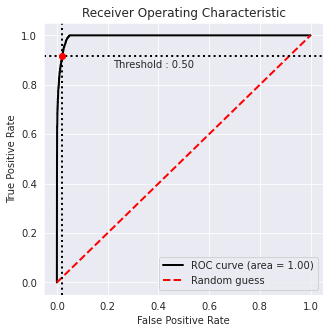

In [7]:
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
score = np.array(y_train)
y = np.array(x_train)

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y, score, labels=["Class 1", "Class 2"])

from sklearn.metrics import roc_auc_score
print(roc_auc_score(x_train, y_train))

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [8]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(x_train, y_train)

Area under the ROC curve : 0.995104


[Text(-200.0, 0, ''),
 Text(0.0, 0, ''),
 Text(200.0, 0, ''),
 Text(400.0, 0, ''),
 Text(600.0, 0, ''),
 Text(800.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1200.0, 0, ''),
 Text(1400.0, 0, ''),
 Text(1600.0, 0, '')]

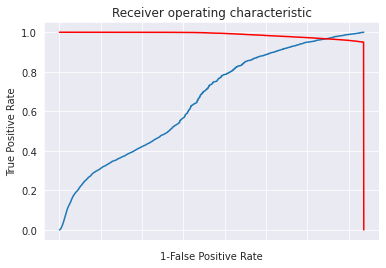

In [11]:
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = pl.subplots()
pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'], color = 'red')
pl.xlabel('1-False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [12]:
columns = []
input_folder = "output_normal_custom_schedule_lr"
list_of_files_in_directory = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
array_of_eval_results = []

total_results = []
for file_name in list_of_files_in_directory:
    splited = os.path.splitext(file_name)
    if splited[1] == '.pth':
        if splited[0] in columns:
            print(file_name)
        else:
            silentremove(os.path.join("output_normal_custom_schedule_lr", file_name))
# for i in columns:
#     print(os.path.join("output_normal_custom_schedule_lr", i))

NameError: name 'silentremove' is not defined

In [13]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 




# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(x_train, y_train)
print(threshold)
# [0.31762762459360921]

# # Find prediction to the dataframe applying threshold
# y_train = [ for i in y_train if i < ]

# # Print confusion Matrix
# from sklearn.metrics import confusion_matrix
# confusion_matrix(x_train, y_train)

[0.17393961548805237]


In [14]:
def my_condition(x, range_x):
    return x > range_x[0] and x <= range_x[1]

ious = [0, 0.25, 0.5, 0.75, 1]
columns = [f"{ious[sd - 1]}-{ious[sd]}" for sd in range(1, len(ious))]
columns.extend(["SumUnAVal",'UnValid','UnValid [%]',"REJECTED_true","REJECTED_false"])
min_area = 0.0
MIN_IOU = 0.2
MIN_THRESH = 0.4
data_to_padas = {}

for id_outcome in range(len(data)):
    un_valid_cnt_all = 0
    data_to_padas.update({ data[id_outcome][0]: [] })
    list_of_iou = []
    rejected = [0,0]
    
    for i in data[id_outcome][1]:
        for val in range(len(data[id_outcome][1][i]['iou'])):
            if data[id_outcome][1][i]['threshold'][val] < MIN_THRESH:
                if data[id_outcome][1][i]['iou'][val] > 0.42:
                    rejected[0] += 1
                else:
                    rejected[1] += 1
                continue
            if data[id_outcome][1][i]['iou'][val] <= MIN_IOU:
                un_valid_cnt_all += 1
                continue
            if data[id_outcome][1][i]['area'][val] > min_area:
                list_of_iou.append(data[id_outcome][1][i]['iou'][val])
                
    for ra in range(1, len(ious)):
        total_r = sum(1 for x in list_of_iou if my_condition(x, [ious[ra-1], ious[ra]]))
        data_to_padas[data[id_outcome][0]].append(total_r/len(list_of_iou))
    
    
    
    data_to_padas[data[id_outcome][0]].append(data_to_padas[data[id_outcome][0]][len(data_to_padas[data[id_outcome][0]]) - 1] - un_valid_cnt_all/len(list_of_iou) - rejected[0]/len(list_of_iou))
    
    data_to_padas[data[id_outcome][0]].append(un_valid_cnt_all)
    data_to_padas[data[id_outcome][0]].append( (un_valid_cnt_all/len(list_of_iou))*100 )
    data_to_padas[data[id_outcome][0]].append(rejected[0]/len(list_of_iou))
    data_to_padas[data[id_outcome][0]].append(rejected[1]/len(list_of_iou))

df_new = pd.DataFrame.from_dict(data_to_padas, orient='index',
                       columns=columns)
# df_new = df_new.sort_index()
df_new = df_new.sort_values('SumUnAVal')
print(f"AREA: {min_area} & MIN_IOU: {MIN_IOU}")
df_new

AREA: 0.0 & MIN_IOU: 0.2


,0-0.25,0.25-0.5,0.5-0.75,0.75-1,SumUnAVal,UnValid,UnValid [%],REJECTED_true,REJECTED_false
model_0067499_amp_on_test_score.json,0.000381,0.016209,0.076659,0.906751,-0.077231,4688,89.397407,0.090008,3.423532
model_0002499_score.json,0.000903,0.011737,0.076923,0.910437,0.045143,4324,78.078729,0.084507,4.240881
model_0004999_score.json,0.000581,0.012977,0.071083,0.915359,0.331978,2306,44.663955,0.136742,3.364904
model_0007499_score.json,0.000833,0.009159,0.063281,0.926728,0.461282,1221,25.416320,0.211282,3.313489
model_0389999_aug_best_score.json,0.002241,0.021774,0.062760,0.913224,0.625360,394,12.616074,0.161703,4.280500
model_0272499_score.json,0.000200,0.006413,0.046092,0.947295,0.670541,1048,21.002004,0.066733,2.419639
model_0059999_score.json,0.000203,0.005083,0.051444,0.943270,0.739325,479,9.739732,0.106547,2.366409
model_0474999_score.json,0.000799,0.008385,0.055500,0.935316,0.783789,508,10.141745,0.050110,2.270912
model_0327499_score.json,0.000822,0.007602,0.053626,0.937949,0.788576,411,8.444627,0.064927,2.354428
model_0139999_score.json,0.000789,0.008478,0.054811,0.935923,0.788841,396,7.807571,0.069006,2.244479


In [ ]:
np.arange(0, 1.0, 0.02)